In [1]:
#!pip freeze

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import holidays
import utils
import seaborn as sns

from skrub import TableVectorizer, GapEncoder
from scipy.stats import uniform, randint

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    RandomizedSearchCV,
    KFold,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error

# Regression Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

Evaluate

In [2]:
%matplotlib inline
sns.set_theme()  # Apply the default theme of seaborn
plt.rcParams["figure.figsize"] = (10, 4)  # Set the figure size for all plots

## Import the data

In [3]:
train_data = pd.read_parquet(Path("data") / "train.parquet")
train_data.set_index("date", inplace=True)

external_data = pd.read_csv(Path("data") / "external_data.csv")
external_data["date"] = pd.to_datetime(external_data["date"])
external_data.set_index("date", inplace=True)

## Data Preprocessing


### Removing duplicate rows
Only external_data has duplicated rows.

In [4]:
# Remove duplicates and keep first occurance
external_data.drop_duplicates(keep="first", inplace=True)

### Handling Missing Values
Only external_data has missing values.

#### Option 1: Drop features with >=50% missing values

In [5]:
threshold = 0.5
bool_drop = external_data.isna().mean() >= threshold

dropped_feat_ext = external_data.columns[bool_drop]
selected_feat_ext = external_data.columns[~bool_drop]

external_data.drop(dropped_feat_ext, axis=1, inplace=True)

print(f"Features dropped: {len(dropped_feat_ext)}")
print(dropped_feat_ext)

Features dropped: 20
Index(['niv_bar', 'geop', 'tn12', 'tn24', 'tx12', 'tx24', 'tminsol', 'sw',
       'tw', 'phenspe1', 'phenspe2', 'phenspe3', 'phenspe4', 'ctype2',
       'nnuage3', 'ctype3', 'hnuage3', 'nnuage4', 'ctype4', 'hnuage4'],
      dtype='object')


## Merge datasets based on Date

In [6]:
# Upsample to hourly frequency
# 3 methods: forward fill, backward fill, linear interpolation
# external_data_resampled = external_data.resample('h').ffill()
# external_data_resampled = external_data.resample('h').bfill()
# external_data_resampled = external_data.resample("h").interpolate(method="linear")
external_data_resampled = external_data.resample("h").interpolate(
    method="time"
)  # Best way to do it

# Reset index if needed
external_data_resampled = external_data_resampled.reset_index()

In [7]:
train_merged = pd.merge(train_data, external_data_resampled, how="inner", on="date")
train_merged

,date,counter_id,counter_name,site_id,site_name,bike_count,counter_installation_date,coordinates,counter_technical_id,latitude,...,rr1,rr3,rr6,rr12,rr24,nnuage1,ctype1,hnuage1,nnuage2,hnuage2
0,2020-09-01 02:00:00,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,0.0,0.0,0.0,0.000000,0.0,NaN,NaN,NaN,NaN,NaN
1,2020-09-01 03:00:00,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,0.0,0.0,0.0,0.000000,0.0,NaN,NaN,NaN,NaN,NaN
2,2020-09-01 04:00:00,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,0.0,0.0,0.0,0.000000,0.0,NaN,NaN,NaN,NaN,NaN
3,2020-09-01 15:00:00,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,0.0,0.0,0.0,0.000000,0.0,2.000000,8.000000,1700.000000,5.000000,2300.000000
4,2020-09-01 18:00:00,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,0.0,0.0,0.0,0.000000,0.0,1.000000,8.000000,1700.000000,7.000000,2400.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496822,2021-09-09 06:00:00,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,445.0,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,...,0.0,0.0,-0.1,1.200000,1.2,7.000000,7.000000,120.000000,6.000000,2520.000000
496823,2021-09-09 10:00:00,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,145.0,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,...,0.0,0.0,0.0,0.766667,1.2,5.666667,7.166667,520.000000,6.333333,1610.000000
496824,2021-09-09 15:00:00,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,218.0,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,...,0.0,0.0,0.0,0.000000,1.2,3.000000,8.000000,1380.000000,4.000000,1560.000000
496825,2021-09-09 22:00:00,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,21.0,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,...,0.0,0.0,0.4,0.600000,1.4,4.000000,3.666667,3713.333333,4.000000,6006.666667


### Handling Outliers
We identify outliers by IQR method and remove them accordingly.

In [8]:
## IQR Outlier Removal Functions
# def remove_outliers_iqr(df, columns):
#    for col in columns:
#        if df[col].dtype != "object":  # Apply only to numerical columns
#            Q1 = df[col].quantile(0.05)
#            Q3 = df[col].quantile(0.95)
#            IQR = Q3 - Q1
#            lower_bound = Q1 - 1.5 * IQR
#            upper_bound = Q3 + 1.5 * IQR
#            # Filter out outliers
#            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
#    return df

In [9]:
## Selecting the numerical columns with the np.number type
# df_numerical = train_merged.select_dtypes(include=np.number)
# df_numerical.head()

In [10]:
## Original number of observations
# print("Train data", train_merged.shape)
## Remove outliers for training data
# train_merged = remove_outliers_iqr(train_merged, df_numerical)
# train_merged.shape
# train_merged.reset_index(drop=True)

## Feature Selection

## Feature Engineering

#### Encode dates

In [11]:
def _encode_dates(X):
    lockdown_periods = (
        ["17-03-2020", "11-05-2020"],
        ["30-10-2020", "15-12-2020"],
        ["03-04-2021", "03-05-2021"],
    )

    lockdown_periods = [
        [pd.to_datetime(start, dayfirst=True), pd.to_datetime(end, dayfirst=True)]
        for start, end in lockdown_periods
    ]

    X = X.copy()  # modify a copy of X

    # Encode the date information from the date column
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday + 1
    X["hour"] = X["date"].dt.hour

    X["is_weekend"] = (X["weekday"] > 5).astype(int)
    X["is_holiday"] = (
        X["date"].apply(lambda x: 1 if x in holidays.FR() else 0).astype(int)
    )
    X["is_lockdown"] = (
        X["date"].apply(
            lambda x: any(start <= x <= end for start, end in lockdown_periods)
        )
    ).astype(int)

    return X.drop(columns=["date"])

In [12]:
train_merged = _encode_dates(train_merged)

In [13]:
train_merged.head()

,counter_id,counter_name,site_id,site_name,bike_count,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,...,nnuage2,hnuage2,year,month,day,weekday,hour,is_weekend,is_holiday,is_lockdown
0,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,...,NaN,NaN,2020,9,1,2,2,0,0,0
1,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,...,NaN,NaN,2020,9,1,2,3,0,0,0
2,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,...,NaN,NaN,2020,9,1,2,4,0,0,0
3,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,...,5.0,2300.0,2020,9,1,2,15,0,0,0
4,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,...,7.0,2400.0,2020,9,1,2,18,0,0,0


# Modelling
1. SGD Regressor (<100k samples)
2. Lasso / ElasticNet (>100k samples + few features should be important)
3. RidgeRegression / SVR(kernel='linear') (>100k samples + many features should be important)

Data for modelling

In [14]:
train_merged.columns

Index(['counter_id', 'counter_name', 'site_id', 'site_name', 'bike_count',
       'counter_installation_date', 'coordinates', 'counter_technical_id',
       'latitude', 'longitude', 'log_bike_count', 'numer_sta', 'pmer', 'tend',
       'cod_tend', 'dd', 'ff', 't', 'td', 'u', 'vv', 'ww', 'w1', 'w2', 'n',
       'nbas', 'hbas', 'cl', 'cm', 'ch', 'pres', 'tend24', 'raf10', 'rafper',
       'per', 'etat_sol', 'ht_neige', 'ssfrai', 'perssfrai', 'rr1', 'rr3',
       'rr6', 'rr12', 'rr24', 'nnuage1', 'ctype1', 'hnuage1', 'nnuage2',
       'hnuage2', 'year', 'month', 'day', 'weekday', 'hour', 'is_weekend',
       'is_holiday', 'is_lockdown'],
      dtype='object')

In [15]:
train_columns = [
    "counter_id",
    # "site_id",
    # "counter_technical_id",
    "latitude",
    "longitude",
    "is_holiday",
    # "year", #high correlation with "month"
    "month",
    "day",
    # "weekday", #'is_weekend" is more correlated to the target
    "hour",
    "is_weekend",
    "is_lockdown",
    "ff",  #: "Vitesse_du_vent_moyen_10mn",
    "t",  #: "Température_K",
    # "u",  #: "humidity", # Correlated with 'Temps_présent' (ww, w1, w2) and "État_du_sol" (etat_sol)
    "vv",  #: "visibility_h",
    "ww",  #: "Temps_présent",
    # "w1",  #: "Temps_passé_1", # Correlated with w2 and ww so kept ww
    # "w2",  #: "Temps_passé_2", # Correlated with w1 and ww so kept ww
    # "n",  #: "Nebulosité_totale",
    "etat_sol",  #: "État_du_sol",
    "ht_neige",  #: "Hauteur_totale_neige",
    "rr1",  #: "Précipitations_1h",
    # "rr3",  #: "Précipitations_3h",   # Correlated with each other so only took rr1
    # "rr6",  #: "Précipitations_6h",   # Correlated with each other so only took rr1
    # "rr12",  #: "Précipitations_12h", # Correlated with each other so only took rr1
    # "rr24",  #: "Précipitations_24h",  # Not so correlated with rr1 but info in etat_sol so kept etat_sol
]

In [16]:
X = train_merged[train_columns]
y = train_merged["log_bike_count"]

In [17]:
import pandas as pd

# Assuming X is a DataFrame and y is a Series
correlations = X.select_dtypes(include=np.number).corrwith(y)

# Display correlations
print(abs(correlations).sort_values(ascending=False))

t              0.329150
hour           0.273085
ff             0.142361
latitude       0.113355
etat_sol       0.102689
ww             0.099892
is_weekend     0.081998
vv             0.080275
is_holiday     0.059295
is_lockdown    0.058883
month          0.056814
longitude      0.044494
rr1            0.032993
day            0.015934
ht_neige       0.005206
n              0.005089
dtype: float64


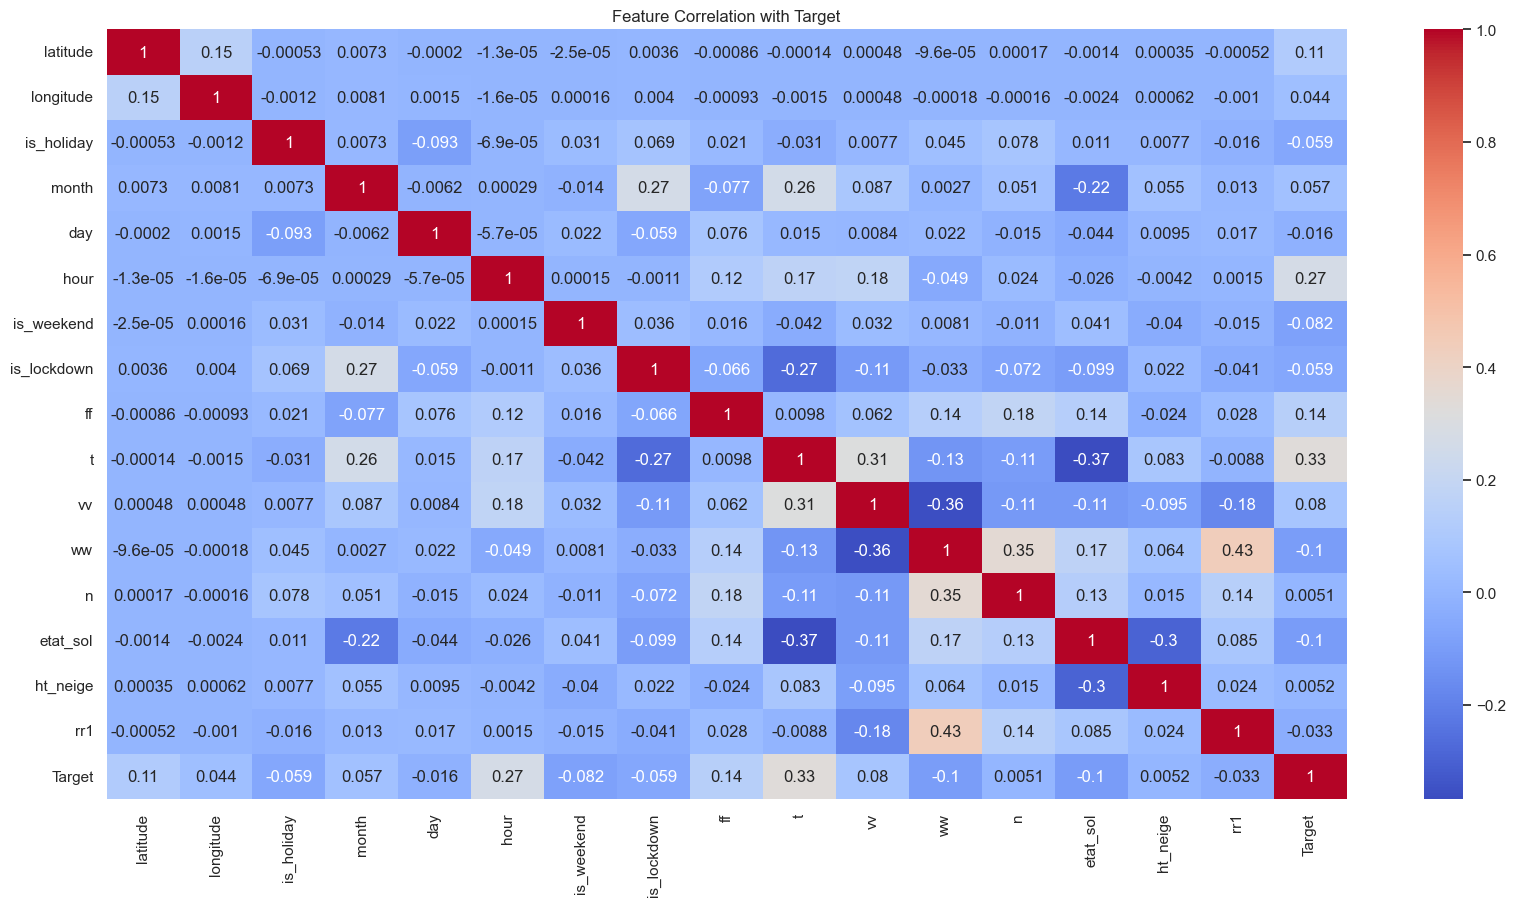

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine X and y for a heatmap
data = X.select_dtypes(include=np.number)
data["Target"] = y

# Compute correlations
correlation_matrix = data.corr()

# Plot heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Feature Correlation with Target")
plt.show()

Train-test split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=3010
)

Model with Vectorized Table

In [126]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "k-Nearest Neighbors": KNeighborsRegressor(),
    "Hist Grad Boosting Tree": HistGradientBoostingRegressor(),
}

In [ ]:
models_accuracy = {}
for name, model in models.items():
    model_i = make_pipeline(TableVectorizer(), model)
    # Train the model
    model_i.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model_i.predict(X_test)

    # Evaluate the model
    accuracy = root_mean_squared_error(y_test, y_pred)
    models_accuracy[name] = accuracy
    print(f"{name}: RMSE = {accuracy:.2f}")

/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The TableVectorizer or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The TableVectorizer or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From 

Linear Regression: RMSE = 1.65


/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The TableVectorizer or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The TableVectorizer or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From 

Ridge Regression: RMSE = 1.33


/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The TableVectorizer or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The TableVectorizer or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From 

Lasso Regression: RMSE = 1.51


/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The TableVectorizer or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The TableVectorizer or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From 

Decision Tree: RMSE = 0.53


/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The TableVectorizer or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The TableVectorizer or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From 

Random Forest: RMSE = 0.37


/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The TableVectorizer or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The TableVectorizer or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From 

k-Nearest Neighbors: RMSE = 1.08


/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The TableVectorizer or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Hist Grad Boosting Tree: RMSE = 0.48


/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The TableVectorizer or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


/var/folders/pj/s8thlv2s5ls_9mngg8y0qvq00000gn/T/ipykernel_93293/3760302168.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="RMSE", data=df, palette="Blues_d")


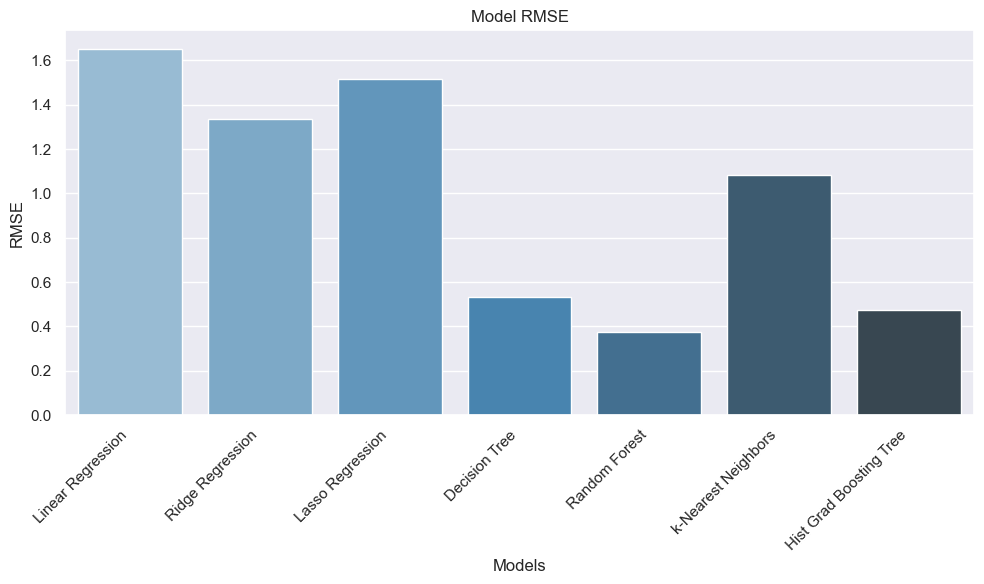

In [20]:
# Convert dictionary to DataFrame
df = pd.DataFrame(list(models_accuracy.items()), columns=["Model", "RMSE"])

# Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="RMSE", data=df, palette="Blues_d")

# Customize the plot
plt.xticks(rotation=45, ha="right")  # Rotate model names for better readability
plt.title("Model RMSE")
plt.xlabel("Models")
plt.ylabel("RMSE")
plt.tight_layout()

# Show the plot
plt.show()

In [21]:
model = make_pipeline(
    TableVectorizer(n_jobs=-1), RandomForestRegressor(n_estimators=100)
)

# Define the parameter grid distribution for RandomForestRegressor
param_distributions = {
    "randomforestregressor__max_depth": randint(10, 50),  # Integers between 10 and 50
    "randomforestregressor__min_samples_split": [2, 5, 10],
}

model_grid_search = RandomizedSearchCV(
    model,
    param_distributions=param_distributions,
    n_iter=5,
    n_jobs=-1,
    cv=5,
    random_state=3010,
)
model_grid_search.fit(X_train, y_train)

/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The TableVectorizer or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The TableVectorizer or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From 

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tablevectorizer',
                                              TableVectorizer(n_jobs=-1)),
                                             ('randomforestregressor',
                                              RandomForestRegressor())]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'randomforestregressor__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1769aba60>,
                                        'randomforestregressor__min_samples_split': [2,
                                                                                     5,
                                                                                     10]},
                   random_state=3010)

In [22]:
## Random Forest
# model = make_pipeline(TableVectorizer(n_jobs=-1),
#                      RandomForestRegressor())
#
# inner_cv = KFold(n_splits=5, shuffle=True, random_state=3010)
#
# param_distributions = {
#    "randomforestregressor__max_depth": randint(10, 50), # Integers between 10 and 100
#    'randomforestregressor__min_samples_split': [2, 5, 10],
#    "randomforestregressor__n_estimators": randint(10, 100)  # Integers between 10 and 100
# }
#
# scores = []
# best_params = []
#
# model_grid_search = RandomizedSearchCV(
#    estimator=model, param_distributions=param_distributions,
#    cv=inner_cv, scoring='neg_root_mean_squared_error',
#    n_jobs=-1, random_state=3010, n_iter=5,
# )
#
# model_grid_search.fit(X_train, y_train)
#
# best_model = model_grid_search.best_estimator_
# best_params.append(model_grid_search.best_params_)
# y_pred = best_model.predict(X_test)
# score = root_mean_squared_error(y_test, y_pred)
# scores.append(score)
#
# final_score = np.mean(scores)

In [ ]:
# print(f"Average RMSE across all folds: {final_score}")
# print(f"The best set of parameters is: {model_grid_search.best_params_}")

Average RMSE across all folds: 0.38012078225847734
The best set of parameters is: {'randomforestregressor__min_samples_split': 2, 'randomforestregressor__max_depth': 40}


Fit the model 

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=3010
)

In [ ]:
# model = make_pipeline(TableVectorizer(), RandomForestRegressor(max_depth=29, n_estimators=95)) #0.73
# model = make_pipeline(TableVectorizer(), HistGradientBoostingRegressor()) #0.71
# model = make_pipeline(TableVectorizer(), HistGradientBoostingRegressor()) #0.71
model = model_grid_search.best_estimator_
# model.fit(X_train, y_train)

<bound method Pipeline.get_params of Pipeline(steps=[('tablevectorizer', TableVectorizer(n_jobs=-1)),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=49, min_samples_split=5))])>


Evaluate

In [25]:
print(f"Train set, RMSE={root_mean_squared_error(y_train, model.predict(X_train)):.2f}")
print(f"Valid set, RMSE={root_mean_squared_error(y_test, model.predict(X_test)):.2f}")

/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The TableVectorizer or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The TableVectorizer or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From 

Train set, RMSE=0.19
Valid set, RMSE=0.39


/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The TableVectorizer or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [26]:
test_data = pd.read_parquet(Path("data") / "final_test.parquet")
test_data_merged = test_data.merge(external_data_resampled, on="date", how="inner")
test_data_merged = _encode_dates(test_data_merged)[X.columns]
# test_data_merged = test_data_merged[X_train.columns]

In [27]:
submission = model.predict(test_data_merged[X.columns])
print(submission.shape)
pd.Series(submission).to_frame().rename_axis("Id").rename(
    columns={0: "log_bike_count"}
).to_csv("submission9_111224.csv")

/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The TableVectorizer or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


(51440,)


/opt/anaconda3/envs/bikes-count/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The TableVectorizer or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
